# Clasificadores de Distancia Minima y 1NN

## Parte 1. Clasificador de la Distancia Minima

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

def distancia_minima(x_train, y_train, x_test):
    """Clasificador de distancia mínima optimizado."""
    # Pre-calcular centroides una sola vez
    clases = np.unique(y_train)
    centroides = np.array([np.mean(x_train[y_train == clase], axis=0) for clase in clases])
    
    # Calcular distancias de forma vectorizada
    distancias = np.linalg.norm(x_test[:, np.newaxis] - centroides, axis=2)
    predicciones = clases[np.argmin(distancias, axis=1)]
    
    # Si x_test es una sola muestra, devolver un solo valor
    return predicciones[0] if x_test.ndim == 1 else predicciones

def preprocesar_datos(df, columna_objetivo):
    """Preprocesa los datos con manejo mejorado de errores."""
    le = LabelEncoder()
    df_processed = df.copy()
    
    for columna in df_processed.columns:
        if df_processed[columna].dtype == 'object':
            df_processed[columna] = le.fit_transform(df_processed[columna].astype(str))
        elif df_processed[columna].dtype == 'datetime64[ns]':
            df_processed[columna] = (df_processed[columna] - pd.Timestamp("1970-01-01")).dt.total_seconds() / (24*60*60)
    
    X = df_processed.drop(columna_objetivo, axis=1)
    y = df_processed[columna_objetivo]

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    if y.dtype == 'object':
        y = le.fit_transform(y.astype(str))
        
    return X, y

def evaluar_modelo(nombre_dataset, df, objetivo, max_samples=None):
    """Evalúa el modelo con límite opcional de muestras."""
    print(f"\nEvaluando dataset: {nombre_dataset}")
    
    # Preprocesamiento inicial
    df_copy = df.copy()
    for col in ['Date of Admission', 'Discharge Date']:
        if col in df_copy.columns:
            df_copy[col] = pd.to_datetime(df_copy[col])

    X, y = preprocesar_datos(df_copy, objetivo)
    
    # Limitar muestras si se especifica
    if max_samples and len(X) > max_samples:
        indices = np.random.choice(len(X), max_samples, replace=False)
        X = X[indices]
        y = y[indices]
    
    # SMOTE con manejo de errores
    try:
        min_samples = min(Counter(y).values())
        k_neighbors = min(min_samples - 1, 5) if min_samples > 1 else 1
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
        X, y = smote.fit_resample(X, y)
    except Exception as e:
        print(f"SMOTE error: {e}. Continuing without oversampling.")
    
    # Hold-Out
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    predicciones = distancia_minima(X_train, y_train, X_test)
    accuracy_holdout = accuracy_score(y_test, predicciones)
    print(f"Accuracy Hold-Out: {accuracy_holdout:.4f}")

    # K-Fold
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    accuracy_scores_kf = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        predicciones = distancia_minima(X_train, y_train, X_test)
        accuracy_scores_kf.append(accuracy_score(y_test, predicciones))
    print(f"Accuracy 10-Fold CV: {np.mean(accuracy_scores_kf):.4f}")

    # Leave-One-Out con barra de progreso y límite de muestras
    if len(X) > 10000:
        print("Omitiendo Leave-One-Out debido al tamaño del dataset")
        return
        
    loo = LeaveOneOut()
    accuracy_scores_loo = []
    
    for train_index, test_index in tqdm(loo.split(X), total=len(X), desc="Leave-One-Out"):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        predicciones = distancia_minima(X_train, y_train, X_test)
        accuracy_scores_loo.append(accuracy_score(y_test, [predicciones]))
    
    print(f"Accuracy Leave-One-Out: {np.mean(accuracy_scores_loo):.4f}")

# Cargar y evaluar datasets
datasets = {
    "healthcare": (pd.read_csv("Dataset\\healthcare_dataset.csv"), 'Medical Condition'),
    "bank": (pd.read_csv("Dataset\\bank_full.csv", sep=";"), 'y'),
    "credit": (pd.read_csv("Dataset\\default_credit_card_clients.csv"), 'default payment next month')
}

for nombre_dataset, (df, objetivo) in datasets.items():
    evaluar_modelo(nombre_dataset, df, objetivo, max_samples=1000)  # Limitar a 1000 muestras


Evaluando dataset: healthcare
Accuracy Hold-Out: 0.1609
Accuracy 10-Fold CV: 0.1713


Leave-One-Out: 100%|██████████| 1056/1056 [00:01<00:00, 827.27it/s]


Accuracy Leave-One-Out: 0.1771

Evaluando dataset: bank
Accuracy Hold-Out: 0.7867
Accuracy 10-Fold CV: 0.7728


Leave-One-Out: 100%|██████████| 1748/1748 [00:01<00:00, 959.60it/s]


Accuracy Leave-One-Out: 0.7695

Evaluando dataset: credit
Accuracy Hold-Out: 0.6632
Accuracy 10-Fold CV: 0.6403


Leave-One-Out: 100%|██████████| 1582/1582 [00:01<00:00, 970.52it/s]

Accuracy Leave-One-Out: 0.6372


## Parte 2: Clasificador 1NN


Evaluando dataset: healthcare
Tamaño del dataset: 55500 muestras
--------------------------------------------------

Hold-Out Validation (70/30):
Accuracy: 0.2802


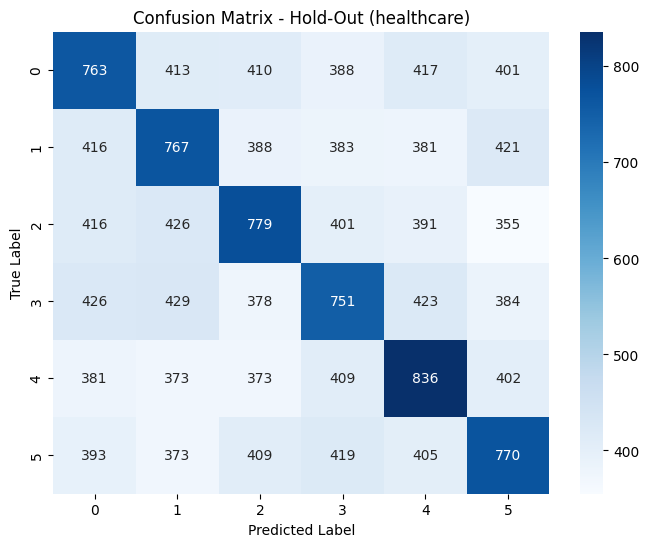


10-Fold Cross-Validation:
Average Accuracy: 0.3148


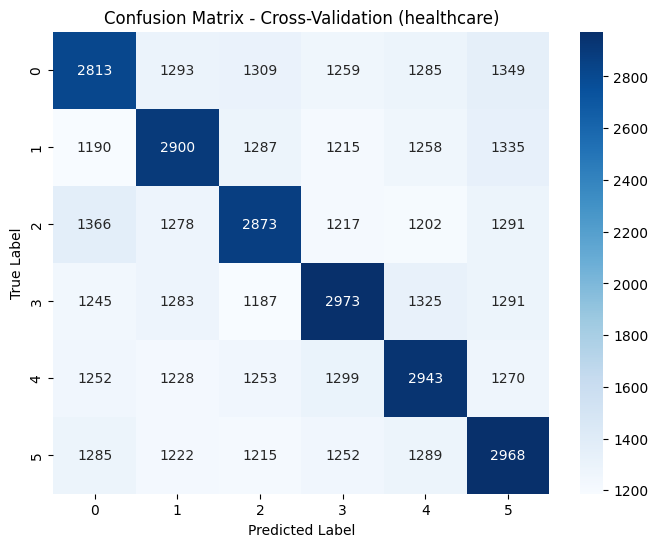


Leave-One-Out Validation:

Dataset muy grande para LOO completo. Usando 1000 muestras aleatorias estratificadas.
Accuracy: 0.1540


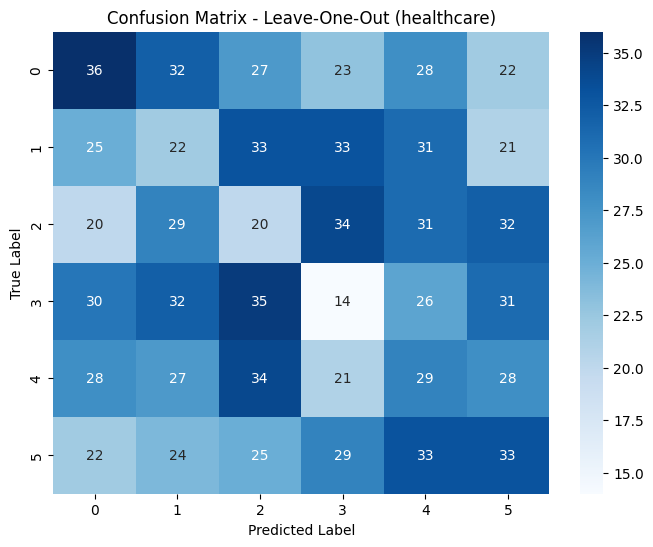


Evaluando dataset: bank
Tamaño del dataset: 45211 muestras
--------------------------------------------------

Hold-Out Validation (70/30):
Accuracy: 0.8742


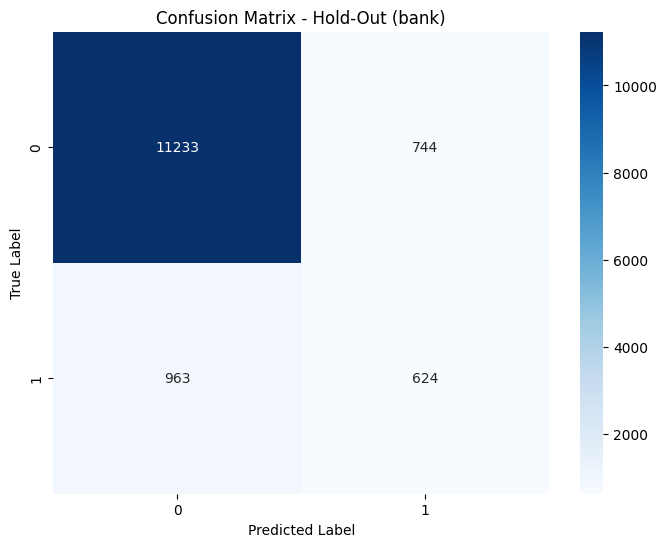


10-Fold Cross-Validation:
Average Accuracy: 0.8751


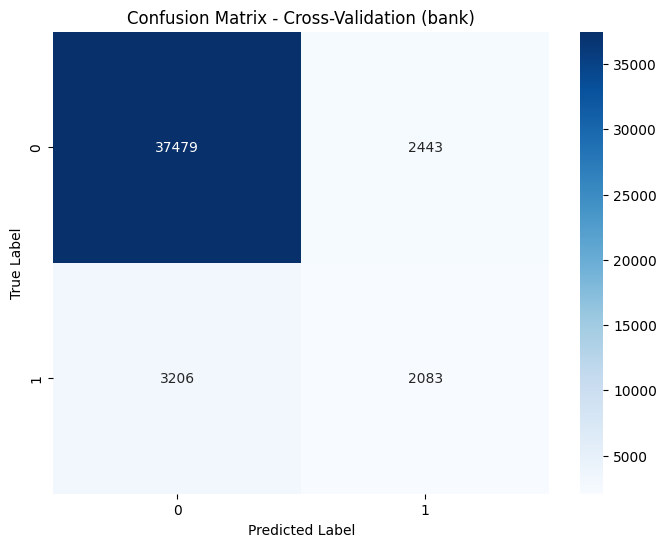


Leave-One-Out Validation:

Dataset muy grande para LOO completo. Usando 1000 muestras aleatorias estratificadas.
Accuracy: 0.8530


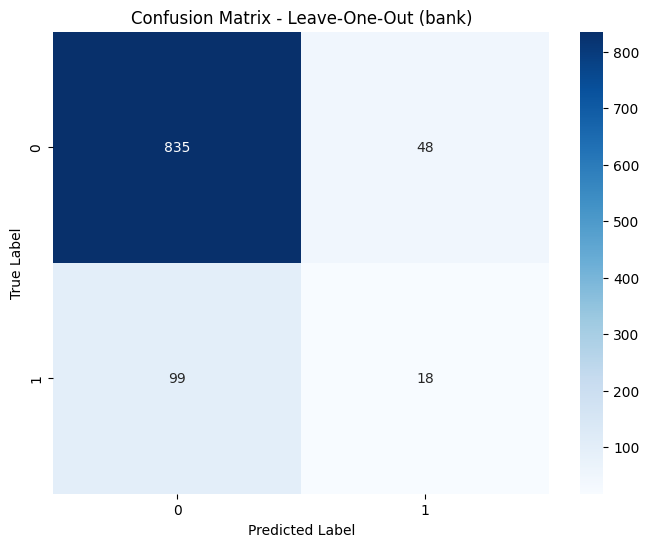


Evaluando dataset: credit
Tamaño del dataset: 30000 muestras
--------------------------------------------------

Hold-Out Validation (70/30):
Accuracy: 0.7270


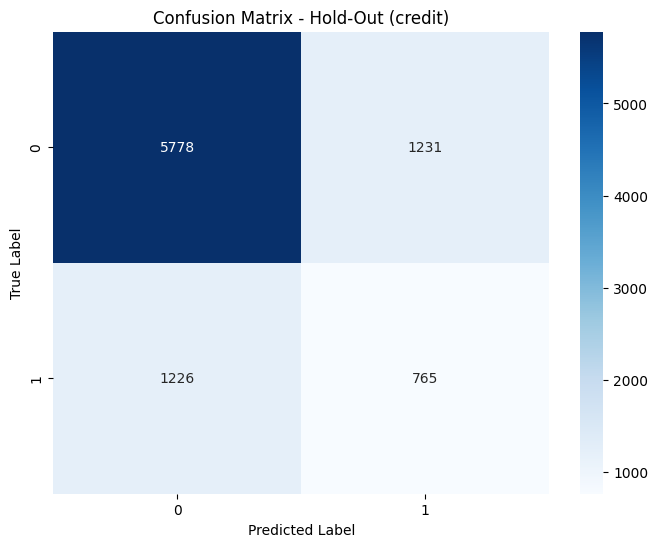


10-Fold Cross-Validation:
Average Accuracy: 0.7271


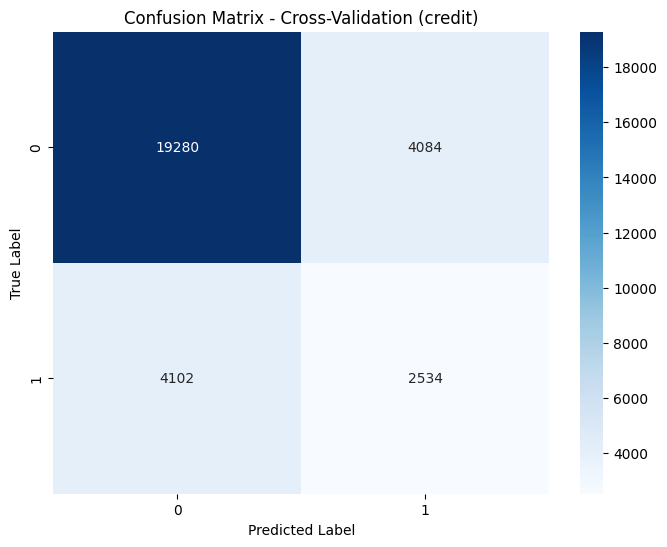


Leave-One-Out Validation:

Dataset muy grande para LOO completo. Usando 1000 muestras aleatorias estratificadas.
Accuracy: 0.7140


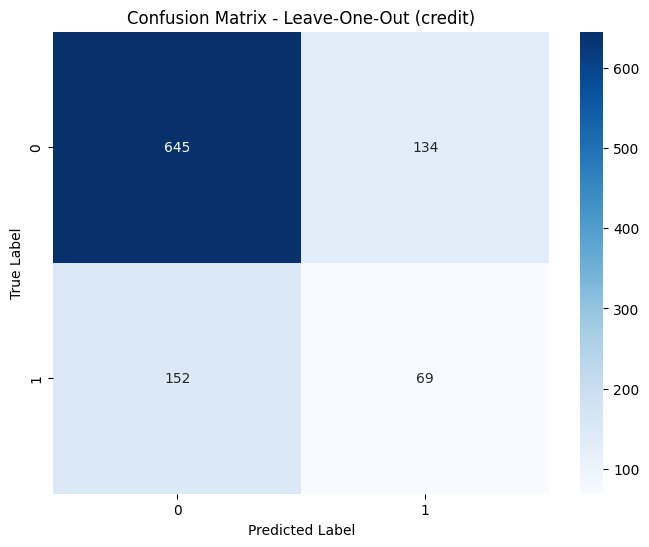

In [28]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_dataset(df, target_column):
    """
    Prepara el dataset separando features y target, y realiza codificación de variables categóricas.
    """
    # Separar features y target
    y = df[target_column]
    X = df.drop(columns=[target_column])
    
    # Convertir variables categóricas a numéricas
    for column in X.columns:
        if X[column].dtype == 'object':
            X[column] = pd.Categorical(X[column]).codes
    
    return X, y

def evaluate_model(y_true, y_pred):
    """
    Calcula las métricas de evaluación: accuracy y matriz de confusión
    """
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    return accuracy, conf_matrix

def plot_confusion_matrix(conf_matrix, title):
    """
    Visualiza la matriz de confusión
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def holdout_validation(X, y):
    """
    Realiza validación Hold-Out 70/30 estratificada
    """
    # División estratificada 70/30
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Escalado de características
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Entrenamiento y predicción
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    
    return evaluate_model(y_test, y_pred)

def cross_validation(X, y):
    """
    Realiza validación cruzada estratificada con 10 folds
    """
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []
    conf_matrices = []
    
    scaler = StandardScaler()
    
    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Escalado
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Entrenamiento y predicción
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)
        
        # Evaluación
        accuracy, conf_matrix = evaluate_model(y_test, y_pred)
        accuracies.append(accuracy)
        conf_matrices.append(conf_matrix)
    
    return np.mean(accuracies), sum(conf_matrices)

def leave_one_out_validation(X, y, max_samples=10000):
    """
    Realiza validación Leave-One-Out con un límite de muestras
    """
    # Si el dataset es más grande que max_samples, tomamos una muestra estratificada
    if len(X) > max_samples:
        print(f"\nDataset muy grande para LOO completo. Usando {max_samples} muestras aleatorias estratificadas.")
        X_sampled, _, y_sampled, _ = train_test_split(
            X, y, 
            train_size=max_samples,
            stratify=y,
            random_state=42
        )
    else:
        X_sampled = X
        y_sampled = y
        
    loo = LeaveOneOut()
    accuracies = []
    all_predictions = []
    all_true = []
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_sampled)
    
    for train_index, test_index in loo.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y_sampled.iloc[train_index], y_sampled.iloc[test_index]
        
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        all_predictions.extend(y_pred)
        all_true.extend(y_test)
    
    return evaluate_model(all_true, all_predictions)

# Función principal para evaluar todos los datasets
def evaluate_datasets(datasets):
    for dataset_name, (df, target_column) in datasets.items():
        print(f"\nEvaluando dataset: {dataset_name}")
        print(f"Tamaño del dataset: {len(df)} muestras")
        print("-" * 50)
        
        # Preparar dataset
        X, y = prepare_dataset(df, target_column)
        
        # Hold-Out Validation
        print("\nHold-Out Validation (70/30):")
        accuracy, conf_matrix = holdout_validation(X, y)
        print(f"Accuracy: {accuracy:.4f}")
        plot_confusion_matrix(conf_matrix, f"Confusion Matrix - Hold-Out ({dataset_name})")
        
        # K-Fold Cross-Validation
        print("\n10-Fold Cross-Validation:")
        accuracy, conf_matrix = cross_validation(X, y)
        print(f"Average Accuracy: {accuracy:.4f}")
        plot_confusion_matrix(conf_matrix, f"Confusion Matrix - Cross-Validation ({dataset_name})")
        
        # Leave-One-Out Validation
        print("\nLeave-One-Out Validation:")
        accuracy, conf_matrix = leave_one_out_validation(X, y, max_samples=1000)
        print(f"Accuracy: {accuracy:.4f}")
        plot_confusion_matrix(conf_matrix, f"Confusion Matrix - Leave-One-Out ({dataset_name})")


if __name__ == "__main__":
    datasets = {
        "healthcare": (pd.read_csv("Dataset\\healthcare_dataset.csv"), 'Medical Condition'),
        "bank": (pd.read_csv("Dataset\\bank_full.csv", sep=";"), 'y'),
        "credit": (pd.read_csv("Dataset\\default_credit_card_clients.csv"), 'default payment next month')
    }
    
    evaluate_datasets(datasets)